In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
spy = pd.read_csv('SPY.csv')
qqq = pd.read_csv('QQQ.csv')

spy_price = spy['Close']
qqq_price = qqq['Close']

print(len(spy_price) == len(qqq_price))
n = len(spy_price)
print(n)

True
3272


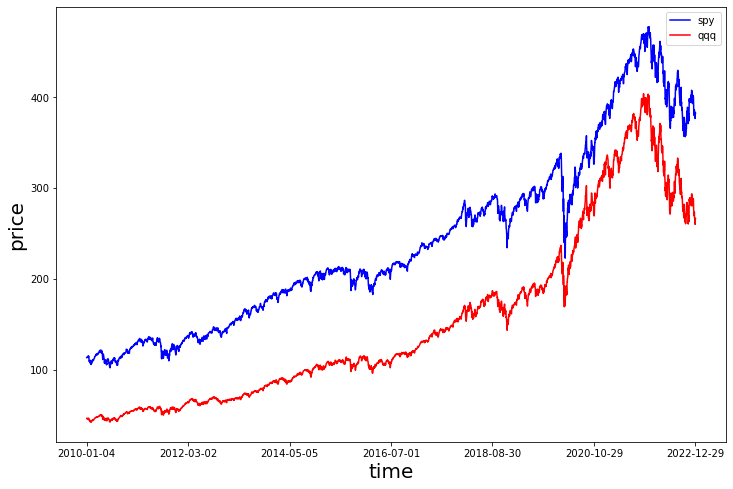

In [3]:
plt.figure(figsize=(12,8))

plt.plot(spy['Date'],spy_price,color='b',label='spy')
plt.plot(spy['Date'],qqq_price,color='r',label='qqq')
plt.xticks(spy['Date'][::n//6])
plt.xlabel('time',size=20)
plt.ylabel('price',size=20)
plt.legend()
plt.show()

In [4]:
diff_price = np.zeros(n)

for i in range(n):
    norm_s = (spy_price[i]-min(spy_price)) / (max(spy_price)-min(spy_price))
    norm_q = (qqq_price[i]-min(qqq_price)) / (max(qqq_price)-min(qqq_price))
    diff_price[i] = norm_s - norm_q

In [5]:
thresh = np.std(diff_price)
print(thresh)

0.04296361784247916


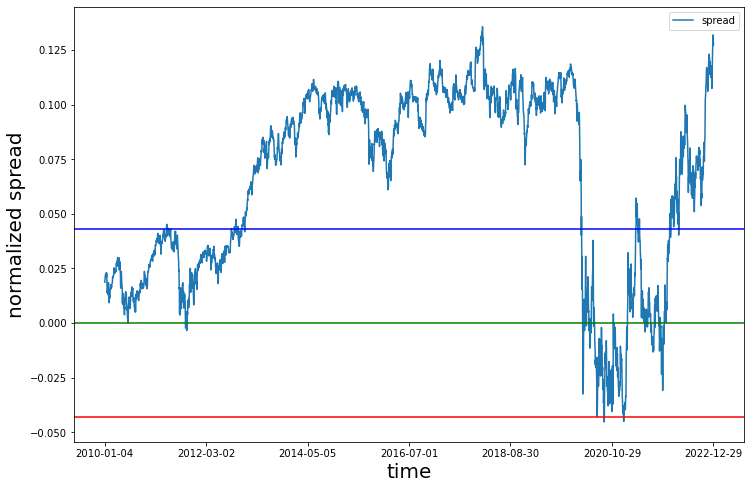

In [6]:
plt.figure(figsize=(12,8))

plt.plot(spy['Date'],diff_price,label='spread')
plt.axhline(y = thresh, color = 'b')
plt.axhline(y = 0, color = 'g')
plt.axhline(y = -thresh, color = 'r')
plt.xticks(spy['Date'][::n//6])
plt.xlabel('time',size=20)
plt.ylabel('normalized spread',size=20)
plt.legend()
plt.show()

In [7]:
strategy = np.zeros(n)

if diff_price[i] > thresh:
    strategy[i] = -1
elif diff_price[i] < thresh:
    strategy[i] = 1
        
for i in range(1,n):
    if diff_price[i] > thresh or (strategy[i-1] == -1 and diff_price[i] > 0):
        strategy[i] = -1
    elif diff_price[i] < -thresh or (strategy[i-1] == 1 and diff_price[i] < 0):
        strategy[i] = 1

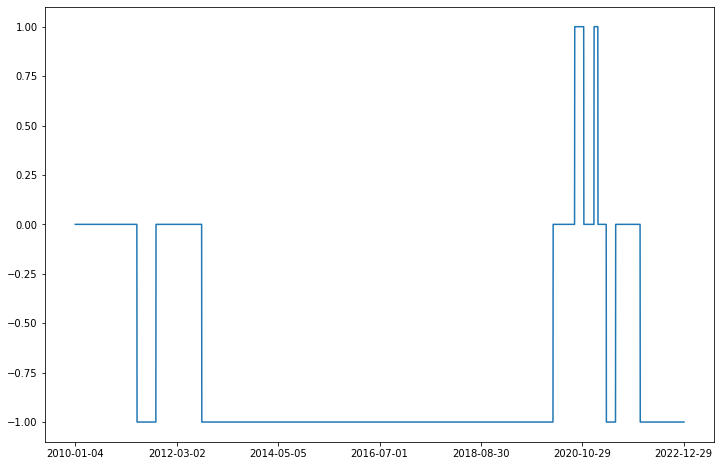

In [9]:
plt.figure(figsize=(12,8))

plt.plot(spy['Date'],strategy)
plt.xticks(spy['Date'][::n//6])
plt.show()

### Backtesting Module

In [68]:
#Calculate daily returns of the strategy
returns = []
short = False
long = False

for i in range(n):
    #Case1: Open Short Position
    if strategy[i] == -1 and not short:
        returns.append(0)
        short = True
          
    #Case2: Open Long Position
    elif strategy[i] == 1 and not long:
        daily_return = 0
        returns.append(daily_return)
        long = True
    
    #Case3: Holding Short Position
    elif short:
        daily_return = 0.5*(spy_price[i-1]/spy_price[i]-1) + 0.5*(qqq_price[i]/qqq_price[i-1]-1)
        returns.append(daily_return)
        #Exit
        if strategy[i] == 0:
            short = False
        else:
            continue
    
    #Case4: Holding Long Position
    elif long:
        daily_return = 0.5*(qqq_price[i-1]/qqq_price[i]-1) + 0.5*(spy_price[i]/spy_price[i-1]-1)
        returns.append(daily_return)
        #Exit
        if strategy[i] == 0:
            long = False
        else:
            continue
            
    else:
        returns.append(0)

In [69]:
#Calculate average daily returns of the two indices as benchmark (long only strategy)
long_only = 0.5*spy_price.pct_change() + 0.5*qqq_price.pct_change()
long_only[0] = 0

/opt/anaconda3/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Start date,2010-01-04
End date,2022-12-30
Total months,155
,Backtest
Annual return,3.5%
Cumulative returns,56.7%
Annual volatility,3.2%
Sharpe ratio,1.09
Calmar ratio,0.74
Stability,0.94
Max drawdown,-4.7%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,4.73,2022-08-04,2022-12-28,NaT,NaN
1,4.35,2012-09-21,2013-04-18,2013-11-29,311
2,4.25,2022-04-04,2022-05-24,2022-08-04,89
3,3.18,2015-12-08,2016-04-28,2016-09-14,202
4,2.85,2014-02-18,2014-05-07,2014-07-22,111


/opt/anaconda3/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/anaconda3/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/anaconda3/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/anaconda3/lib/python3.8/site-packages/pyfolio/timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to si

Stress Events,mean,min,max
US downgrade/European Debt Crisis,0.05%,-0.33%,0.54%
Fukushima,0.00%,0.00%,0.00%
EZB IR Event,-0.03%,-0.30%,0.22%
Flash Crash,0.00%,0.00%,0.00%
Apr14,-0.01%,-0.73%,0.55%
Oct14,0.01%,-0.67%,0.34%
Fall2015,0.03%,-0.63%,0.67%
Recovery,0.01%,-0.64%,0.65%
New Normal,0.02%,-1.17%,1.67%


/opt/anaconda3/lib/python3.8/site-packages/pyfolio/timeseries.py:1228: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


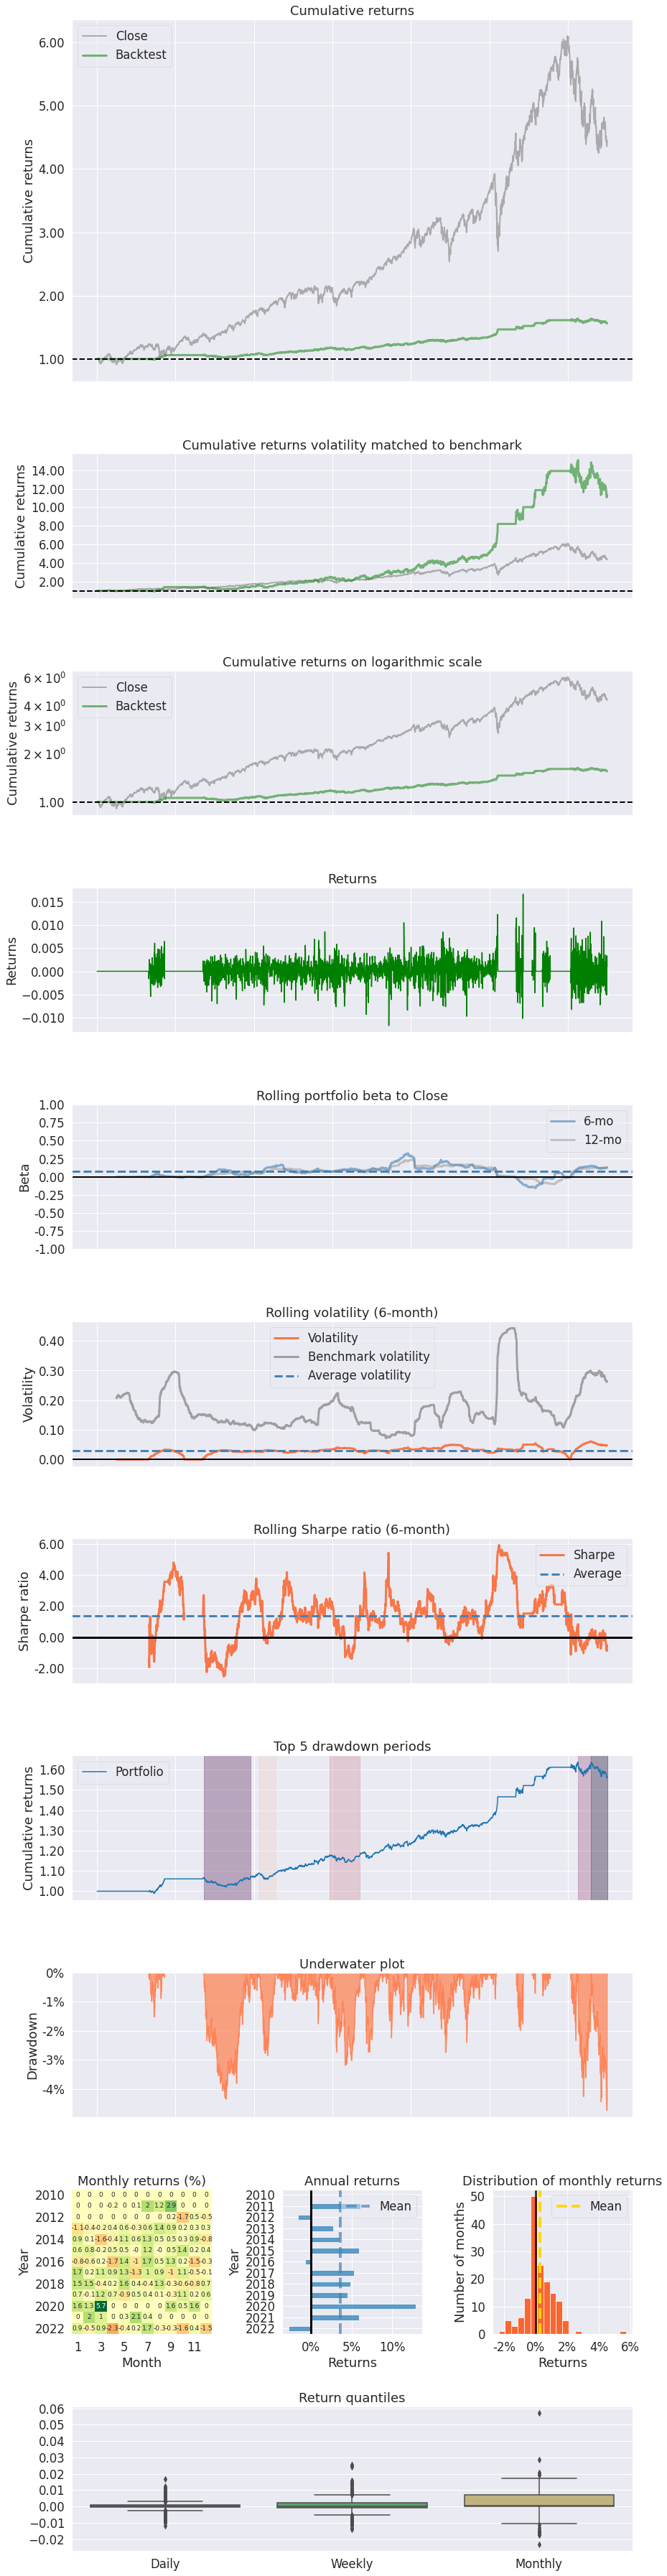

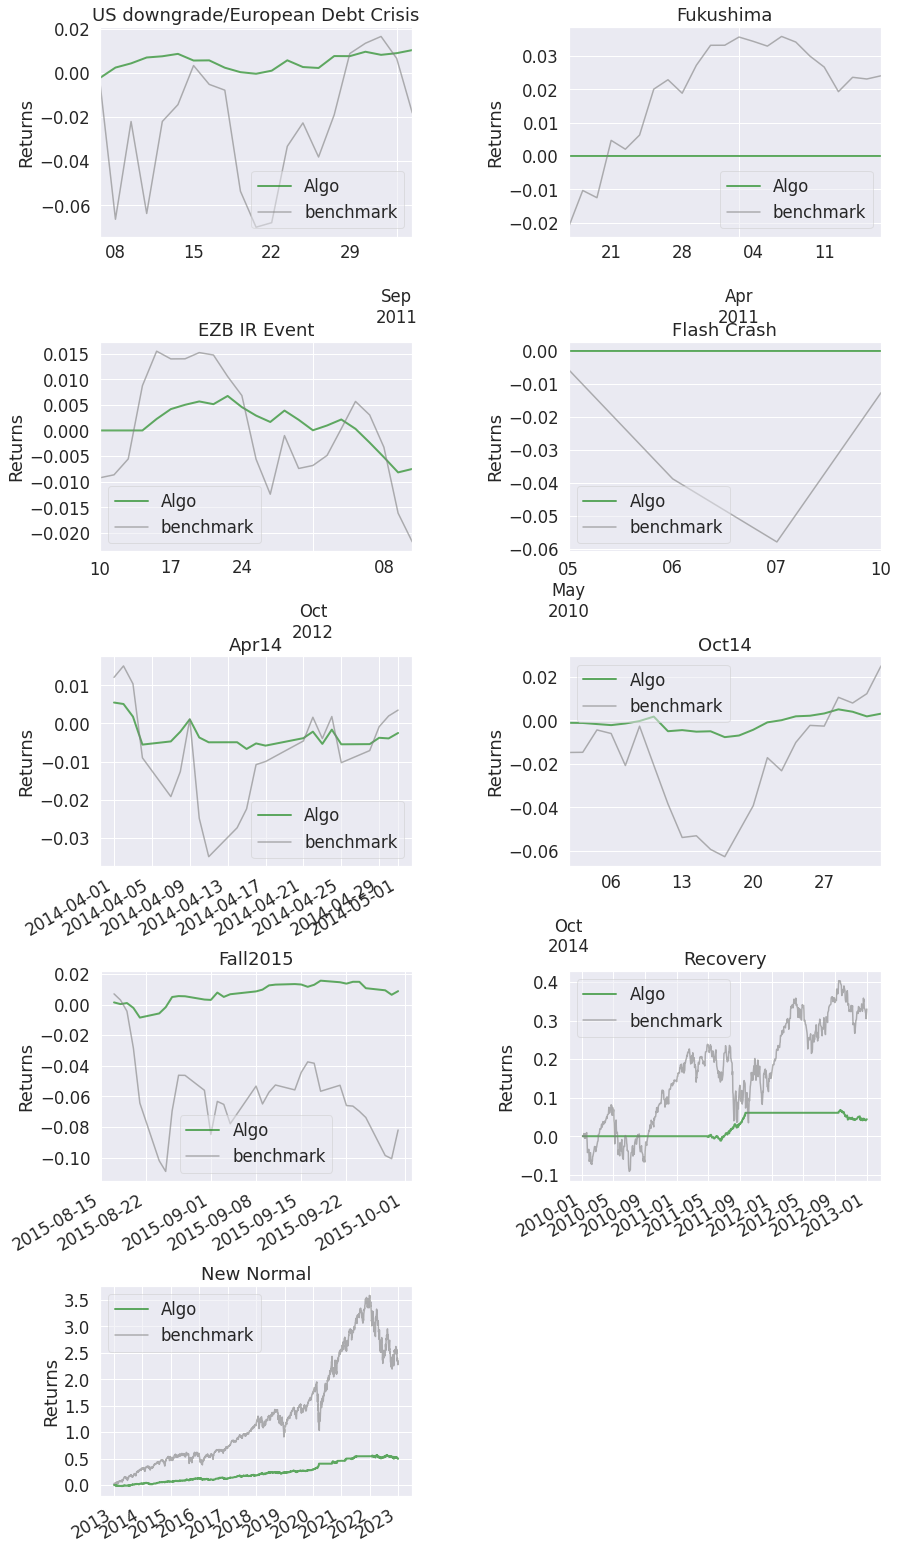

In [70]:
#Backtesting Visualization
import pyfolio as pf
from datetime import datetime
dates = pd.to_datetime(spy['Date'])
rets = pd.Series(data = returns, index = dates)
rets = rets.tz_localize('UTC')
long_only.index = dates
long_only = long_only.tz_localize('UTC')
pf.create_full_tear_sheet(returns=rets, benchmark_rets = long_only)